In [1]:
# [1] Importe und Datensets laden
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------------------------
# Konfiguration:
# ------------------------------------------------
N_WEEKS = 3               # Anzahl der zu betrachtenden Aufzeichnungswochen
VEHICLES_PER_SECTOR = 10  # Anzahl Fahrzeuge pro Sektor in Schritt 3B
HEATMAP_VEHICLE_ID = 1106000461  # Fahrzeug-ID für die Heatmap in Schritt [8]
# ------------------------------------------------

# Daten laden (Pfad ggf. anpassen)
df_trips = pd.read_csv('REM2030_cleaned.csv')      # Trips/Bewegungsdaten
df_cars = pd.read_csv('REM2030_car_cleaned.csv')     # Fahrzeuge, Sektor, Größe, Firma etc.

# Vorab: vehicle_size in df_cars als String festlegen (wichtig für spätere Filter)
df_cars['vehicle_size'] = df_cars['vehicle_size'].astype(str)

print(">>> Übersicht 'df_cars' (Fahrzeug-Infos) <<<")
display(df_cars.head(5))
print("Anzahl Fahrzeuge in df_cars:", df_cars['id'].nunique())

print("\n>>> Übersicht 'df_trips' (Trip-Daten) <<<")
display(df_trips.head(5))
print("Anzahl Zeilen (Trips) in df_trips:", len(df_trips))

# Merge für spätere Firmen- vs.-Wochen-Auswertungen und Filterungen
df_merged = pd.merge(df_trips, df_cars, on='id', how='inner')

print("\n>>> Übersicht 'df_merged' (gemeinsamer Datensatz) <<<")
display(df_merged.head(5))
print("Anzahl Fahrzeuge in df_merged:", df_merged['id'].nunique())
print("Anzahl Zeilen (Trips) in df_merged:", len(df_merged))


>>> Übersicht 'df_cars' (Fahrzeug-Infos) <<<


,id,vehicle_size,economic_sector,nace_section,company_id
0,1106000161,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
1,1106000171,3,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
2,1106000181,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
3,1106000191,2,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
4,1106000201,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615


Anzahl Fahrzeuge in df_cars: 629

>>> Übersicht 'df_trips' (Trip-Daten) <<<


,id,deptyear,deptmonth,deptday,depthour,deptminute,arryear,arrmonth,arrday,arrhour,arrminute,distance,distance_to_company,departure,arrival,travel_time,days_duration,avg_speed,calendar_week,week_day
0,1106000161,2011,6,16,8,7,2011,6,16,9,55,2.66,0.03,2011-06-16 08:07:00,2011-06-16 09:55:00,108.0,1,1.48,24,Thursday
1,1106000161,2011,6,16,10,32,2011,6,16,10,34,3.19,2.28,2011-06-16 10:32:00,2011-06-16 10:34:00,2.0,1,95.70,24,Thursday
2,1106000161,2011,6,16,15,15,2011,6,16,15,17,0.63,2.24,2011-06-16 15:15:00,2011-06-16 15:17:00,2.0,1,18.90,24,Thursday
3,1106000161,2011,6,17,11,47,2011,6,17,11,51,1.70,0.70,2011-06-17 11:47:00,2011-06-17 11:51:00,4.0,1,25.50,24,Friday
4,1106000161,2011,6,17,11,51,2011,6,17,11,52,1.54,1.18,2011-06-17 11:51:00,2011-06-17 11:52:00,1.0,1,92.40,24,Friday


Anzahl Zeilen (Trips) in df_trips: 86463

>>> Übersicht 'df_merged' (gemeinsamer Datensatz) <<<


,id,deptyear,deptmonth,deptday,depthour,deptminute,arryear,arrmonth,arrday,arrhour,...,arrival,travel_time,days_duration,avg_speed,calendar_week,week_day,vehicle_size,economic_sector,nace_section,company_id
0,1106000161,2011,6,16,8,7,2011,6,16,9,...,2011-06-16 09:55:00,108.0,1,1.48,24,Thursday,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
1,1106000161,2011,6,16,10,32,2011,6,16,10,...,2011-06-16 10:34:00,2.0,1,95.70,24,Thursday,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
2,1106000161,2011,6,16,15,15,2011,6,16,15,...,2011-06-16 15:17:00,2.0,1,18.90,24,Thursday,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
3,1106000161,2011,6,17,11,47,2011,6,17,11,...,2011-06-17 11:51:00,4.0,1,25.50,24,Friday,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615
4,1106000161,2011,6,17,11,51,2011,6,17,11,...,2011-06-17 11:52:00,1.0,1,92.40,24,Friday,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615


Anzahl Fahrzeuge in df_merged: 629
Anzahl Zeilen (Trips) in df_merged: 86500


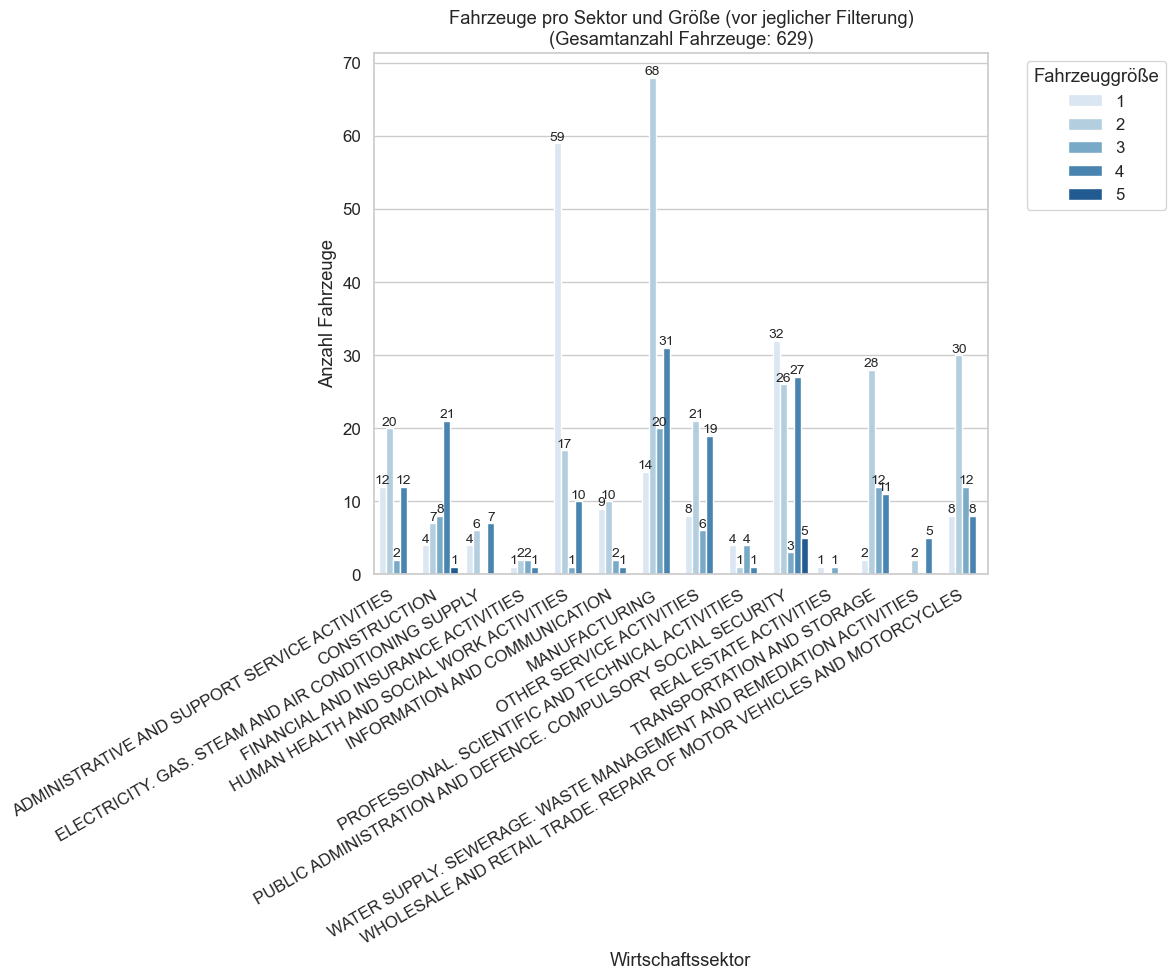

In [2]:
# [1A] Vor der Filterung: Diagramme und Auswertungen zur Kontrolle
sns.set_theme(style="whitegrid", font_scale=1.1)

# (1) Fahrzeuge pro Sektor & Größe (vorher, ungefiltert) => nur aus df_cars
df_veh_sector_size_before = (
    df_cars
    .groupby(['economic_sector','vehicle_size'])['id']
    .nunique()
    .reset_index(name='count_vehicles')
)

total_vehicles_before = df_veh_sector_size_before['count_vehicles'].sum()

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=df_veh_sector_size_before,
    x='economic_sector',
    y='count_vehicles',
    hue='vehicle_size',
    palette='Blues'
)
plt.title(f"Fahrzeuge pro Sektor und Größe (vor jeglicher Filterung)\n"
          f"(Gesamtanzahl Fahrzeuge: {total_vehicles_before})")
plt.xticks(rotation=30, ha='right')
plt.xlabel("Wirtschaftssektor")
plt.ylabel("Anzahl Fahrzeuge")

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.legend(title="Fahrzeuggröße", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

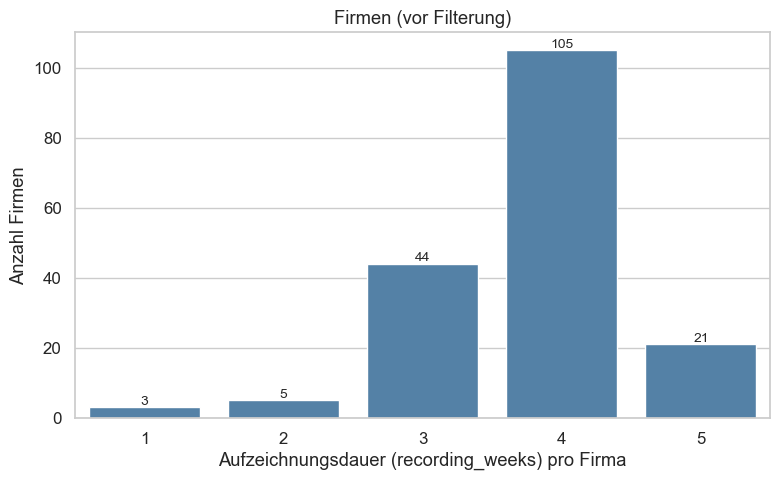

Anzahl der Firmen mit einer Aufzeichnungsdauer von 3 Kalenderwochen: 44
Anzahl der Firmen mit einer Aufzeichnungsdauer von 4 Kalenderwochen: 105
Anzahl der Firmen mit einer Aufzeichnungsdauer von 5 Kalenderwochen: 21
Anzahl der Firmen mit einer Aufzeichnungsdauer von 6 Kalenderwochen: 0


In [3]:
# (2) Firmen vs. Aufzeichnungsdauer in Kalenderwochen
#     - Wir ermitteln die "recording_weeks" pro Firma anhand
#       frühestem/spätestem Aufzeichnungsdatum.
#     - Dies ersetzt das alte, fehlerhafte Zählen distinct calendar_weeks.

# Zunächst Start- und Endzeiten in datetime konvertieren
df_merged["departure_date"] = pd.to_datetime(
    df_merged[['deptyear', 'deptmonth', 'deptday']].rename(columns={'deptyear':'year','deptmonth':'month','deptday':'day'})
)
df_merged["arrival_date"] = pd.to_datetime(
    df_merged[['arryear', 'arrmonth', 'arrday']].rename(columns={'arryear':'year','arrmonth':'month','arrday':'day'})
)

# Für jede Firma: frühestes/spätestes Datum
company_durations = df_merged.groupby("company_id").agg(
    earliest_record=("departure_date", "min"),
    latest_record=("arrival_date", "max")
)
# Aufzeichnungsdauer in KW
company_durations["recording_weeks"] = (
    (company_durations["latest_record"] - company_durations["earliest_record"]).dt.days // 7
) + 1

# Countplot der "recording_weeks" je Firma
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=company_durations, x='recording_weeks', color="steelblue")
plt.title("Firmen (vor Filterung)")
plt.xlabel("Aufzeichnungsdauer (recording_weeks) pro Firma")
plt.ylabel("Anzahl Firmen")
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()

# Kontrolle: Wie viele Firmen haben 3, 4, 5 oder 6 Wochen
record_counts = company_durations["recording_weeks"].value_counts()
count_3_weeks = record_counts.get(3, 0)
count_4_weeks = record_counts.get(4, 0)
count_5_weeks = record_counts.get(5, 0)
count_6_weeks = record_counts.get(6, 0)
print(f"Anzahl der Firmen mit einer Aufzeichnungsdauer von 3 Kalenderwochen: {count_3_weeks}")
print(f"Anzahl der Firmen mit einer Aufzeichnungsdauer von 4 Kalenderwochen: {count_4_weeks}")
print(f"Anzahl der Firmen mit einer Aufzeichnungsdauer von 5 Kalenderwochen: {count_5_weeks}")
print(f"Anzahl der Firmen mit einer Aufzeichnungsdauer von 6 Kalenderwochen: {count_6_weeks}")

In [4]:
# (3) Debug-Ausgabe: Firmen mit größter Aufzeichnungsdauer + ihre Fahrzeuge
max_weeks = company_durations["recording_weeks"].max()
firms_with_max = company_durations[company_durations["recording_weeks"] == max_weeks]
print(f"\n=== DEBUG: Firmen mit maximaler Aufzeichnungsdauer ({max_weeks} KW) ===")
for cid in firms_with_max.index:
    firm_weeks = firms_with_max.loc[cid, "recording_weeks"]
    earliest = firms_with_max.loc[cid, "earliest_record"]
    latest = firms_with_max.loc[cid, "latest_record"]
    print(f" -> Firma {cid} hat {firm_weeks} Wochen. earliest={earliest.date()}, latest={latest.date()}")

    # Fahrzeuge dieser Firma + jeweilige earliest/späteste Fahrt
    vehicles_of_firm = df_merged[df_merged["company_id"] == cid]["id"].unique()
    for v in vehicles_of_firm:
        df_v = df_merged[df_merged["id"] == v]
        v_earliest = df_v["departure_date"].min()
        v_latest = df_v["arrival_date"].max()
        v_rec_weeks = ((v_latest - v_earliest).days // 7) + 1
        print(f"    Fahrzeug {v}: earliest={v_earliest.date()}, latest={v_latest.date()}, rec_weeks={v_rec_weeks}")
print("=== DEBUG Ende ===\n")

# (4) Filtern und Ausgeben aller Firmen mit 5 oder 6 Wochen (Kontrolle)
records_5_6_weeks = company_durations[company_durations["recording_weeks"].isin([5, 6])]
print("\nFirmen, die eine Aufzeichnungsdauer von 5 oder 6 Wochen haben:")
display(records_5_6_weeks)

# (5) Firmen, deren Aufzeichnung über mehr als ein Kalenderjahr geht (Kontrolle)
cross_year_records = company_durations[
    company_durations["earliest_record"].dt.year < company_durations["latest_record"].dt.year
]
print("\nFirmen, deren Aufzeichnung über mehr als ein Kalenderjahr geht:")
display(cross_year_records)


=== DEBUG: Firmen mit maximaler Aufzeichnungsdauer (5 KW) ===
 -> Firma 110718 hat 5 Wochen. earliest=2011-07-07, latest=2011-08-05
    Fahrzeug 1107000642: earliest=2011-07-25, latest=2011-08-04, rec_weeks=2
    Fahrzeug 1107000652: earliest=2011-07-25, latest=2011-08-05, rec_weeks=2
    Fahrzeug 1107000662: earliest=2011-07-25, latest=2011-08-03, rec_weeks=2
    Fahrzeug 1107000832: earliest=2011-07-07, latest=2011-08-05, rec_weeks=5
 -> Firma 120914 hat 5 Wochen. earliest=2012-09-10, latest=2012-10-10
    Fahrzeug 1209514356: earliest=2012-09-25, latest=2012-10-10, rec_weeks=3
    Fahrzeug 1209557462: earliest=2012-09-10, latest=2012-10-10, rec_weeks=5
    Fahrzeug 1209650507: earliest=2012-09-10, latest=2012-10-10, rec_weeks=5
 -> Firma 130301 hat 5 Wochen. earliest=2013-03-06, latest=2013-04-08
    Fahrzeug 1303573527: earliest=2013-03-06, latest=2013-04-08, rec_weeks=5
    Fahrzeug 1303573642: earliest=2013-03-06, latest=2013-04-05, rec_weeks=5
    Fahrzeug 1303643700: earliest=

,earliest_record,latest_record,recording_weeks
company_id,,,
110718,2011-07-07,2011-08-05,5
120914,2012-09-10,2012-10-10,5
130301,2013-03-06,2013-04-08,5
130801,2013-08-05,2013-09-03,5
130802,2013-08-09,2013-09-08,5
130806,2013-08-01,2013-09-04,5
130902,2013-09-25,2013-10-23,5
130905,2013-09-26,2013-10-25,5
130907,2013-09-25,2013-10-25,5



Firmen, deren Aufzeichnung über mehr als ein Kalenderjahr geht:


,earliest_record,latest_record,recording_weeks
company_id,,,


In [5]:
# [2] Wochentage als Integer mappen
day_map = {
    'monday':    1,
    'tuesday':   2,
    'wednesday': 3,
    'thursday':  4,
    'friday':    5,
    'saturday':  6,
    'sunday':    7
}
df_merged['week_day'] = (
    df_merged['week_day']
    .astype(str)
    .str.lower()
    .map(day_map)
)

print(">>> Mapping der Wochentage <<<")
display(df_merged[['week_day','calendar_week','depthour','arrhour','deptminute','arrminute','vehicle_size']].head(10))


>>> Mapping der Wochentage <<<


,week_day,calendar_week,depthour,arrhour,deptminute,arrminute,vehicle_size
0,4,24,8,9,7,55,1
1,4,24,10,10,32,34,1
2,4,24,15,15,15,17,1
3,5,24,11,11,47,51,1
4,5,24,11,11,51,52,1
5,5,24,12,12,17,20,1
6,1,25,10,10,10,37,1
7,1,25,13,13,15,43,1
8,2,25,9,9,43,47,1
9,2,25,10,11,46,15,1


In [6]:
# [3] Firmen-/Fahrzeug-Filterung nach Aufzeichnungswochen (N-WEEKS-Logik)
# ---------------------------------------------------------------
# • Pro Fahrzeug: jede Woche (Mo–So) mit mind. einer Fahrt ist eine Aufzeichnungswoche.
#   Lücken werden ignoriert, z.B. [1, 3, 5] → num_week: [1, 2, 3].
# • Pro Firma: nur Wochen, in denen ALLE Fahrzeuge Aufzeichnungen haben (Intersektion).
# • Firmen bleiben nur erhalten, wenn diese gemeinsame Wochenanzahl >= N_WEEKS ist.
#   Falls mehr als N_WEEKS, nur die ersten N chronologisch.
# • Dann nur Trips aus diesen "N" gemeinsamen Wochen behalten.

df_merged['calendar_week'] = df_merged['calendar_week'].astype(int)

# a) Pro Fahrzeug: Liste der belegten KW
df_vehicle_weeks = (
    df_merged.groupby('id')['calendar_week']
    .unique()
    .reset_index()
)
df_vehicle_weeks['all_weeks'] = df_vehicle_weeks['calendar_week'].apply(lambda x: sorted(list(x)))
df_vehicle_weeks['weeks_set'] = df_vehicle_weeks['all_weeks'].apply(set)
df_vehicle_weeks = df_vehicle_weeks[['id','all_weeks','weeks_set']]

# b) Firmenzuordnung
df_id_firma = df_merged[['id','company_id']].drop_duplicates()
df_vehicle_weeks = pd.merge(df_vehicle_weeks, df_id_firma, on='id', how='left')

# c) Intersektion der Wochen pro Firma (Gemeinsame Wochen aller Fahrzeuge)
def intersect_sets(sets):
    return set.intersection(*sets) if sets else set()

df_company_weeks = (
    df_vehicle_weeks
    .groupby('company_id')['weeks_set']
    .apply(lambda s: intersect_sets(list(s)))
    .reset_index()
    .rename(columns={'weeks_set':'common_weeks'})
)
df_company_weeks['common_weeks_sorted'] = df_company_weeks['common_weeks'].apply(lambda x: sorted(list(x)))
df_company_weeks['num_common_weeks'] = df_company_weeks['common_weeks_sorted'].apply(len)

# d) Nur Firmen mit ausreichender gemeinsamer Wochen-Anzahl (>= N_WEEKS)
valid_companies = df_company_weeks[df_company_weeks['num_common_weeks'] >= N_WEEKS]['company_id'].unique()
df_filtered = df_merged[df_merged['company_id'].isin(valid_companies)].copy()

# e) Mapping (id, calendar_week) -> recording_week (nur für die ersten N gemeinsamen Wochen)
mapping_rows = []
company_common_weeks = {}
for _, row in df_company_weeks.iterrows():
    cid = row['company_id']
    weeks_sorted = row['common_weeks_sorted'][:N_WEEKS]
    company_common_weeks[cid] = weeks_sorted

for idx, row in df_vehicle_weeks.iterrows():
    cid = row['company_id']
    if cid not in company_common_weeks:
        continue
    common_weeks = company_common_weeks[cid]
    for i, cw in enumerate(common_weeks, start=1):
        mapping_rows.append({
            'id': row['id'],
            'calendar_week': cw,
            'recording_week': i
        })

df_map = pd.DataFrame(mapping_rows)

df_filtered = pd.merge(
    df_filtered,
    df_map,
    on=['id','calendar_week'],
    how='inner'
)

print(f">>> Datensatz nach Firmen- und Wochen-Filterung (gemeinsame Aufzeichnungswochen ≥ {N_WEEKS}) <<<")
print("Anzahl Zeilen (Trips):", len(df_filtered))
print("Anzahl Fahrzeuge:", df_filtered['id'].nunique())
print("Anzahl Firmen:", df_filtered['company_id'].nunique())
display(df_filtered.head(10))

>>> Datensatz nach Firmen- und Wochen-Filterung (gemeinsame Aufzeichnungswochen ≥ 3) <<<
Anzahl Zeilen (Trips): 52492
Anzahl Fahrzeuge: 435
Anzahl Firmen: 130


,id,deptyear,deptmonth,deptday,depthour,deptminute,arryear,arrmonth,arrday,arrhour,...,avg_speed,calendar_week,week_day,vehicle_size,economic_sector,nace_section,company_id,departure_date,arrival_date,recording_week
0,1106000161,2011,6,16,8,7,2011,6,16,9,...,1.48,24,4,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-16,2011-06-16,1
1,1106000161,2011,6,16,10,32,2011,6,16,10,...,95.70,24,4,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-16,2011-06-16,1
2,1106000161,2011,6,16,15,15,2011,6,16,15,...,18.90,24,4,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-16,2011-06-16,1
3,1106000161,2011,6,17,11,47,2011,6,17,11,...,25.50,24,5,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-17,2011-06-17,1
4,1106000161,2011,6,17,11,51,2011,6,17,11,...,92.40,24,5,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-17,2011-06-17,1
5,1106000161,2011,6,17,12,17,2011,6,17,12,...,68.20,24,5,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-17,2011-06-17,1
6,1106000161,2011,6,20,10,10,2011,6,20,10,...,7.04,25,1,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-20,2011-06-20,2
7,1106000161,2011,6,20,13,15,2011,6,20,13,...,38.87,25,1,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-20,2011-06-20,2
8,1106000161,2011,6,21,9,43,2011,6,21,9,...,39.75,25,2,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-21,2011-06-21,2
9,1106000161,2011,6,21,10,46,2011,6,21,11,...,20.44,25,2,1,PUBLIC ADMINISTRATION AND DEFENCE. COMPULSORY ...,15,110615,2011-06-21,2011-06-21,2


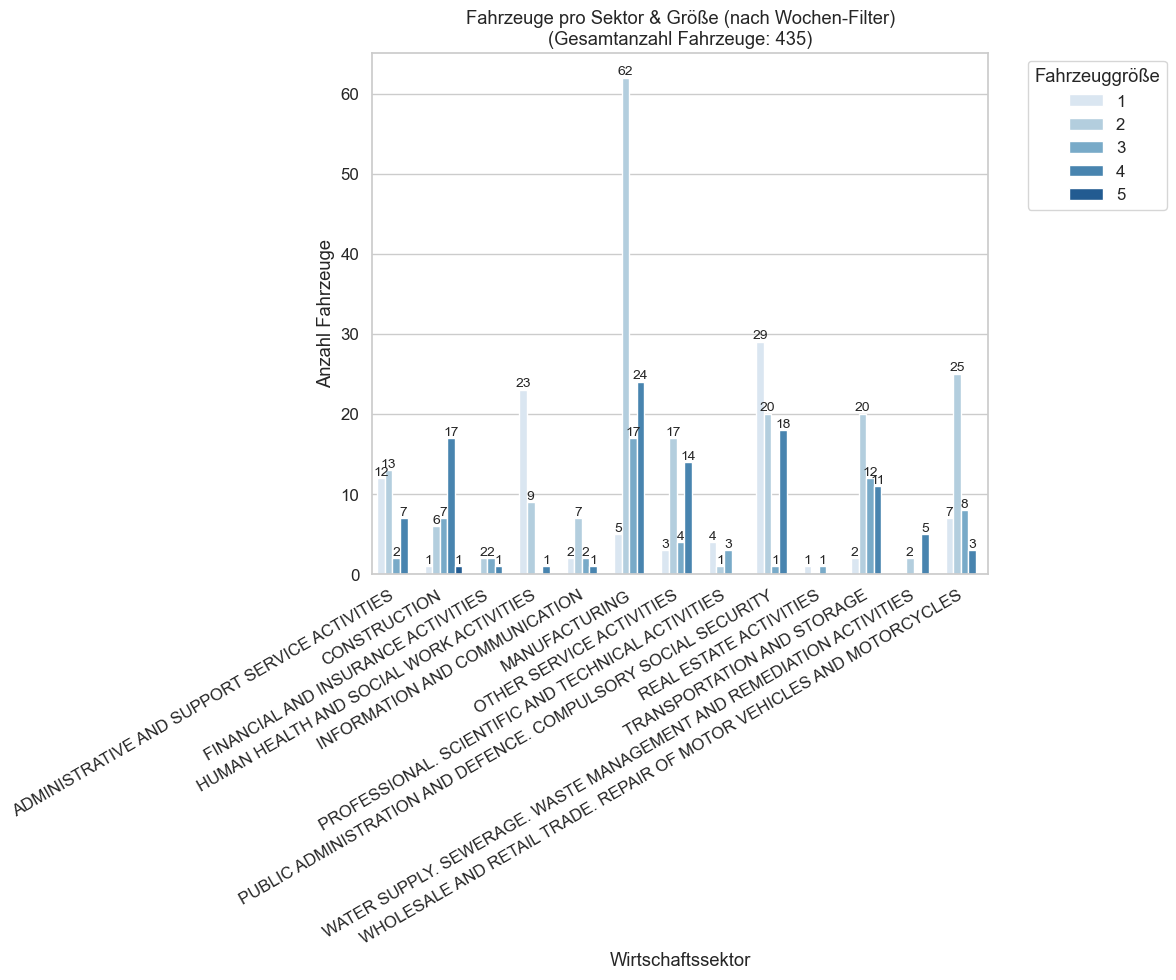

In [7]:
# [3A] Diagramme nach Wochen-Filterung, vor Fahrzeug-Selektion
df_filtered['vehicle_size'] = df_filtered['vehicle_size'].astype(str)

# (a) Fahrzeuge pro Sektor & Größe
df_veh_sector_size_after = (
    df_filtered
    .drop_duplicates(subset='id')
    .groupby(['economic_sector','vehicle_size'])['id']
    .nunique()
    .reset_index(name='count_vehicles')
)
total_vehicles_after = df_veh_sector_size_after['count_vehicles'].sum()

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=df_veh_sector_size_after,
    x='economic_sector',
    y='count_vehicles',
    hue='vehicle_size',
    palette='Blues'
)
plt.title(f"Fahrzeuge pro Sektor & Größe (nach Wochen-Filter)\n"
          f"(Gesamtanzahl Fahrzeuge: {total_vehicles_after})")
plt.xticks(rotation=30, ha='right')
plt.xlabel("Wirtschaftssektor")
plt.ylabel("Anzahl Fahrzeuge")

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.legend(title="Fahrzeuggröße", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


>>> Sektor 'CONSTRUCTION' <<<
Verfügbare Fahrzeuge im Sektor (nach Filterung): 32
  Größe 1: Benötigt 1, verfügbar 1 -> Zufällig gezogen
  Größe 2: Benötigt 2, verfügbar 6 -> Zufällig gezogen
  Größe 3: Benötigt 2, verfügbar 7 -> Zufällig gezogen
  Größe 4: Benötigt 5, verfügbar 17 -> Zufällig gezogen
  Größe 5: Benötigt 0, verfügbar 1 -> Zufällig gezogen
Ausgewählte Fahrzeuge für Sektor 'CONSTRUCTION': 10

>>> Sektor 'TRANSPORTATION AND STORAGE' <<<
Verfügbare Fahrzeuge im Sektor (nach Filterung): 45
  Größe 1: Benötigt 0, verfügbar 2 -> Zufällig gezogen
  Größe 2: Benötigt 5, verfügbar 20 -> Zufällig gezogen
  Größe 3: Benötigt 2, verfügbar 12 -> Zufällig gezogen
  Größe 4: Benötigt 2, verfügbar 11 -> Zufällig gezogen
  Größe 5: Benötigt 0, verfügbar 0 -> Keine Fahrzeuge dieser Größe vorhanden.
  Zusätzlich 1 Fahrzeuge aus Rest ergänzt.
Ausgewählte Fahrzeuge für Sektor 'TRANSPORTATION AND STORAGE': 10

>>> Sektor 'ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES' <<<
Verfügbare Fahrzeu

,id,economic_sector,vehicle_size,company_id
0,1203624569,CONSTRUCTION,1,120304
1,1106000481,CONSTRUCTION,2,110601
2,1202563809,CONSTRUCTION,2,120210
3,1106000801,CONSTRUCTION,3,110611
4,1202564245,CONSTRUCTION,3,120210
5,1106000461,CONSTRUCTION,4,110601
6,1106000471,CONSTRUCTION,4,110601
7,1106000861,CONSTRUCTION,4,110611
8,1203642504,CONSTRUCTION,4,120304
9,1203570341,CONSTRUCTION,4,120312


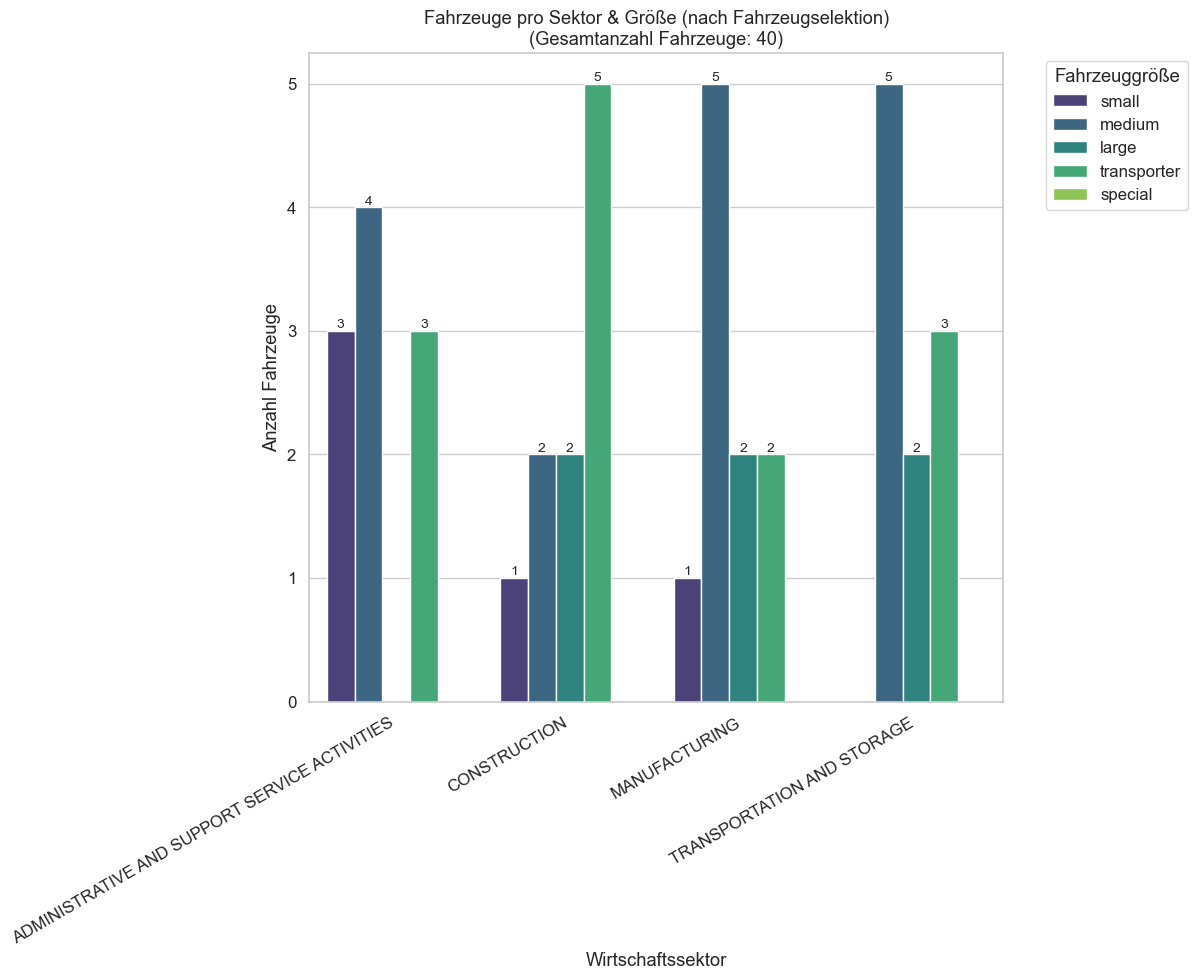


>>> Nach Sektor-Fahrzeugfilter: Anzahl Trips: 4935
Anzahl eindeutiger Fahrzeuge: 40
Anzahl Firmen: 26


In [8]:
# [3B] Fahrzeugselektion pro economic_sector
# -----------------------------------------
# Für jeden Sektor werden genau VEHICLES_PER_SECTOR Fahrzeuge ausgewählt,
# aufgeteilt nach prozentualem Anteil der Fahrzeuggröße.
# Alle Fahrten dieser Fahrzeuge (in den N_WEEKS) bleiben erhalten.

sector_filters = {
    'CONSTRUCTION': {
        'vehicles_per_sector': VEHICLES_PER_SECTOR,
        'vehicle_size_proportions': {'1': 0.10, '2': 0.17, '3': 0.20, '4': 0.51, '5': 0.02}
    },
    'TRANSPORTATION AND STORAGE': {
        'vehicles_per_sector': VEHICLES_PER_SECTOR,
        'vehicle_size_proportions': {'1': 0.04, '2': 0.53, '3': 0.23, '4': 0.21, '5': 0.00}
    },
    'ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES': {
        'vehicles_per_sector': VEHICLES_PER_SECTOR,
        'vehicle_size_proportions': {'1': 0.26, '2': 0.43, '3': 0.04, '4': 0.26, '5': 0.00}
    },
    'MANUFACTURING': {
        'vehicles_per_sector': VEHICLES_PER_SECTOR,
        'vehicle_size_proportions': {'1': 0.11, '2': 0.51, '3': 0.15, '4': 0.23, '5': 0.00}
    }
}

selected_vehicles_list = []

for sector, params in sector_filters.items():
    vehicles_per_sector = params['vehicles_per_sector']
    vehicle_size_proportions = params['vehicle_size_proportions']
    
    sector_vehicles = (
        df_filtered[df_filtered['economic_sector'] == sector]
        .drop_duplicates('id')
        .copy()
    )
    print(f"\n>>> Sektor '{sector}' <<<")
    print("Verfügbare Fahrzeuge im Sektor (nach Filterung):", len(sector_vehicles))

    sector_selection = pd.DataFrame()
    for size, proportion in vehicle_size_proportions.items():
        n_sample = int(round(vehicles_per_sector * proportion))
        subset = sector_vehicles[sector_vehicles['vehicle_size'] == size]
        print(f"  Größe {size}: Benötigt {n_sample}, verfügbar {len(subset)}", end=' ')
        if len(subset) == 0:
            print("-> Keine Fahrzeuge dieser Größe vorhanden.")
            sample_subset = pd.DataFrame()
        else:
            if len(subset) < n_sample:
                sample_subset = subset
                print(f"-> Zu wenige, übernehme alle ({len(subset)})")
            else:
                sample_subset = subset.sample(n=n_sample, random_state=42)
                print("-> Zufällig gezogen")
        sector_selection = pd.concat([sector_selection, sample_subset], ignore_index=True)
    
    # Falls Rundungen zu < vehicles_per_sector führen, ergänzen wir ggf.
    if len(sector_selection) < vehicles_per_sector:
        additional_needed = vehicles_per_sector - len(sector_selection)
        remaining = sector_vehicles[~sector_vehicles['id'].isin(sector_selection['id'])]
        if not remaining.empty:
            additional = remaining.sample(n=min(additional_needed, len(remaining)), random_state=42)
            sector_selection = pd.concat([sector_selection, additional], ignore_index=True)
            print(f"  Zusätzlich {len(additional)} Fahrzeuge aus Rest ergänzt.")
    
    # Falls Überschuss > vehicles_per_sector, reduzieren
    if len(sector_selection) > vehicles_per_sector:
        sector_selection = sector_selection.sample(n=vehicles_per_sector, random_state=42)
        print(f"  Überschuss reduziert auf {vehicles_per_sector} Fahrzeuge.")
    
    print(f"Ausgewählte Fahrzeuge für Sektor '{sector}': {len(sector_selection)}")
    selected_vehicles_list.append(sector_selection)

df_filtered_vehicles = pd.concat(selected_vehicles_list, ignore_index=True)

print("\n>>> Zusammenfassung der ausgewählten Fahrzeuge (Step 3B) <<<")
print("Gesamtanzahl ausgewählter Fahrzeuge:", df_filtered_vehicles['id'].nunique())
display(df_filtered_vehicles[['id','economic_sector','vehicle_size','company_id']].drop_duplicates())

# -----------------------------------------------------------
# Neuer Graph: Fahrzeuge pro Sektor & Größe nach Fahrzeugselektion (Schritt 3B)
df_veh_sector_size_after_selection = (
    df_filtered_vehicles
    .drop_duplicates(subset='id')
    .groupby(['economic_sector', 'vehicle_size'])['id']
    .nunique()
    .reset_index(name='count_vehicles')
)

# Definiere die gewünschte Reihenfolge und die Umbenennungen
size_order = ['1', '2', '3', '4', '5']
size_labels = {'1': 'small', '2': 'medium', '3': 'large', '4': 'transporter', '5': 'special'}

# Setze die Reihenfolge als kategorische Ordnung und sortiere anschließend
df_veh_sector_size_after_selection['vehicle_size'] = pd.Categorical(
    df_veh_sector_size_after_selection['vehicle_size'],
    categories=size_order,
    ordered=True
)
df_veh_sector_size_after_selection = df_veh_sector_size_after_selection.sort_values('vehicle_size')

# Mappe die ursprünglichen Werte auf die neuen Bezeichnungen
df_veh_sector_size_after_selection['vehicle_size'] = df_veh_sector_size_after_selection['vehicle_size'].map(size_labels)

total_vehicles_after_selection = df_veh_sector_size_after_selection['count_vehicles'].sum()

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=df_veh_sector_size_after_selection,
    x='economic_sector',
    y='count_vehicles',
    hue='vehicle_size',
    palette='viridis'
)
plt.title(f"Fahrzeuge pro Sektor & Größe (nach Fahrzeugselektion)\n"
          f"(Gesamtanzahl Fahrzeuge: {total_vehicles_after_selection})")
plt.xticks(rotation=30, ha='right')
plt.xlabel("Wirtschaftssektor")
plt.ylabel("Anzahl Fahrzeuge")
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)
plt.legend(title="Fahrzeuggröße", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()
#------------------------------------------------------------

# Reduzieren auf diese ausgewählten Fahrzeuge
df_final = df_filtered[df_filtered['id'].isin(df_filtered_vehicles['id'])].copy()
print("\n>>> Nach Sektor-Fahrzeugfilter: Anzahl Trips:", len(df_final))
print("Anzahl eindeutiger Fahrzeuge:", df_final['id'].nunique())
print("Anzahl Firmen:", df_final['company_id'].nunique())

In [9]:
# [4] Kalender-Tabelle erstellen (N_WEEKS x 7 Tage x 24 Stunden x 60 Min)
all_weeks = list(range(1, N_WEEKS+1))
all_days = range(1, 8)   # 1..7
all_hours = range(0, 24) # 0..23
all_minutes = range(0, 60)

cal_rows = []
for w in all_weeks:
    for d in all_days:
        for h in all_hours:
            for m in all_minutes:
                cal_rows.append({
                    'num_week': w,
                    'week_day': d,
                    'day_hour': h,
                    'hour_minute': m
                })
df_calendar = pd.DataFrame(cal_rows)

print("\n>>> Kalender-Tabelle (Beispiel) <<<")
display(df_calendar.head(10))
print("Anzahl Zeilen im Kalender:", len(df_calendar))


>>> Kalender-Tabelle (Beispiel) <<<


,num_week,week_day,day_hour,hour_minute
0,1,1,0,0
1,1,1,0,1
2,1,1,0,2
3,1,1,0,3
4,1,1,0,4
5,1,1,0,5
6,1,1,0,6
7,1,1,0,7
8,1,1,0,8
9,1,1,0,9


Anzahl Zeilen im Kalender: 30240


In [10]:
# [5] Statusberechnung (Fahrend, ParkendFirma, ParkendRemote) pro Minute pro Fahrzeug
vehicles = df_final['id'].unique()
all_results = []

for vid in vehicles:
    df_cal_v = df_calendar.copy()
    df_cal_v['id'] = vid
    
    df_trips_v = df_final[df_final['id'] == vid].copy()
    df_trips_v.sort_values(by=['recording_week','week_day','depthour','deptminute'], inplace=True)

    # Fahrzeuginfos übernehmen
    if 'vehicle_size' in df_trips_v.columns:
        df_cal_v['vehicle_size'] = df_trips_v['vehicle_size'].iloc[0]
    if 'company_id' in df_trips_v.columns:
        df_cal_v['company_id'] = df_trips_v['company_id'].iloc[0]
    if 'economic_sector' in df_trips_v.columns:
        df_cal_v['economic_sector'] = df_trips_v['economic_sector'].iloc[0]

    # Dummy-Spalten
    df_cal_v['distance'] = 0
    df_cal_v['avg_speed'] = 0
    df_cal_v['Fahrend'] = 0
    df_cal_v['ParkendFirma'] = 0
    df_cal_v['ParkendRemote'] = 0

    trip_list = df_trips_v.to_dict('records')
    trip_index = 0
    total_trips = len(trip_list)
    last_distance = 0.0

    for i, row_cal in df_cal_v.iterrows():
        cal_week = row_cal['num_week']
        cal_day = row_cal['week_day']
        cal_hour = row_cal['day_hour']
        cal_minute = row_cal['hour_minute']
        cal_min_of_day = cal_hour * 60 + cal_minute

        if trip_index >= total_trips:
            # Keine weiteren Trips => Parken
            if last_distance > 1:
                df_cal_v.at[i, 'ParkendRemote'] = 1
            else:
                df_cal_v.at[i, 'ParkendFirma'] = 1
            continue

        found_trip = False
        while trip_index < total_trips:
            cur_trip = trip_list[trip_index]
            trip_w = cur_trip['recording_week']
            trip_d = cur_trip['week_day']
            dep_h = int(cur_trip['depthour'])
            dep_m = int(cur_trip['deptminute'])
            arr_h = int(cur_trip['arrhour'])
            arr_m = int(cur_trip['arrminute'])
            dist_c = float(cur_trip.get('distance_to_company', 0))
            spd = float(cur_trip.get('avg_speed', 0))

            dep_min_of_day = dep_h*60 + dep_m
            arr_min_of_day = arr_h*60 + arr_m

            if (cal_week == trip_w) and (cal_day == trip_d):
                if dep_min_of_day <= cal_min_of_day <= arr_min_of_day:
                    df_cal_v.at[i, 'Fahrend'] = 1
                    df_cal_v.at[i, 'avg_speed'] = spd
                    found_trip = True
                    if cal_min_of_day == arr_min_of_day:
                        last_distance = dist_c
                        trip_index += 1
                    break
                else:
                    if cal_min_of_day < dep_min_of_day:
                        break
                    else:
                        last_distance = dist_c
                        trip_index += 1
            else:
                break

        if not found_trip:
            # => Parken
            if last_distance > 1:
                df_cal_v.at[i, 'ParkendRemote'] = 1
            else:
                df_cal_v.at[i, 'ParkendFirma'] = 1

    all_results.append(df_cal_v)

summary = pd.concat(all_results, ignore_index=True)
summary.sort_values(by=['id','num_week','week_day','day_hour','hour_minute'], inplace=True)

print("\n>>> Beispielhafte Zeilen aus summary: ")
display(summary.head(40))


C:\Users\pasca\AppData\Local\Temp\ipykernel_15204\1003813567.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40.89' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cal_v.at[i, 'avg_speed'] = spd
C:\Users\pasca\AppData\Local\Temp\ipykernel_15204\1003813567.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cal_v.at[i, 'avg_speed'] = spd
C:\Users\pasca\AppData\Local\Temp\ipykernel_15204\1003813567.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cal_v.at[i, 'avg_speed'] = spd
C:\Users\pasca\AppD


>>> Beispielhafte Zeilen aus summary: 


,num_week,week_day,day_hour,hour_minute,id,vehicle_size,company_id,economic_sector,distance,avg_speed,Fahrend,ParkendFirma,ParkendRemote
0,1,1,0,0,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
1,1,1,0,1,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
2,1,1,0,2,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
3,1,1,0,3,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
4,1,1,0,4,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
5,1,1,0,5,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
6,1,1,0,6,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
7,1,1,0,7,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
8,1,1,0,8,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0
9,1,1,0,9,1106000461,4,110601,CONSTRUCTION,0,0.0,0,1,0


In [11]:
# [6] Kontrolle: Summe(Fahrend, ParkendFirma, ParkendRemote) == 1 ?
summary['Sum3'] = summary[['Fahrend','ParkendFirma','ParkendRemote']].sum(axis=1)
problem_rows = summary[summary['Sum3'] != 1]
print("Anzahl problematischer Zeilen (Sum3 != 1):", len(problem_rows))
if not problem_rows.empty:
    display(problem_rows.head(10))

Anzahl problematischer Zeilen (Sum3 != 1): 0


In [12]:
# [7] Spalten sortieren + CSV-Ausgabe
columns_sorted = [
    'id','company_id','economic_sector','num_week','week_day','day_hour','hour_minute',
    'vehicle_size','distance','avg_speed','Fahrend','ParkendFirma','ParkendRemote'
]
summary = summary[columns_sorted]

csv_filename = "fahrzeug_zusammenfassung.csv"
summary.to_csv(
    csv_filename,
    index=False,
    encoding='utf-8-sig',
    sep=';',
    decimal=',',
)
print("CSV-Datei erstellt:", csv_filename)

CSV-Datei erstellt: fahrzeug_zusammenfassung.csv


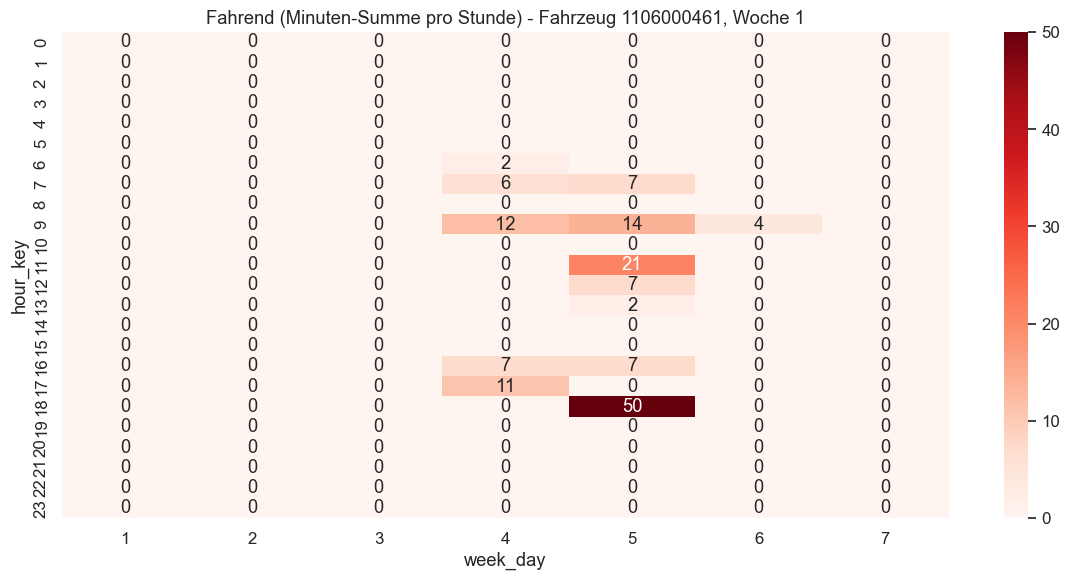

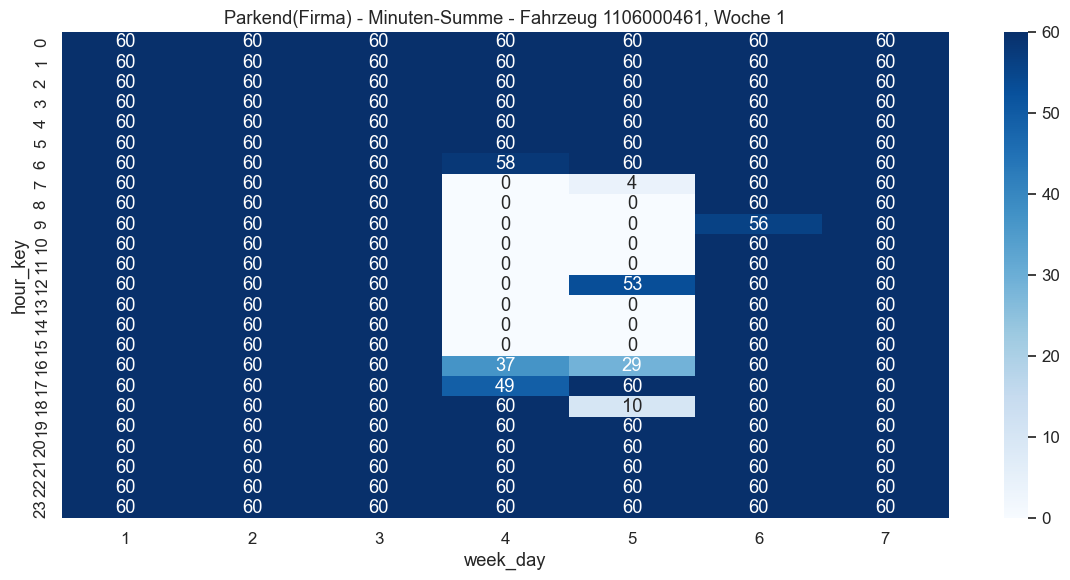

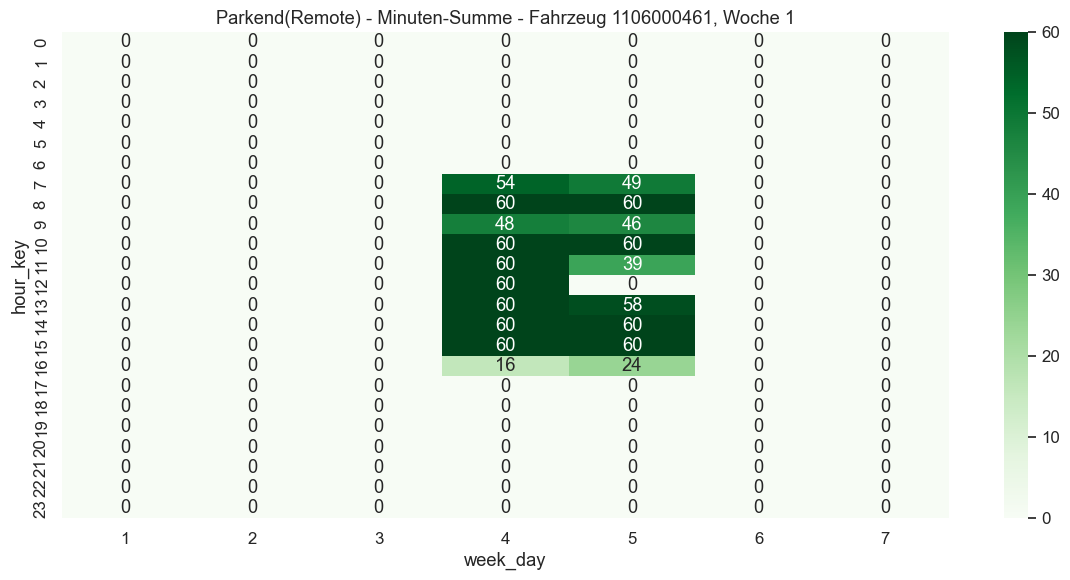

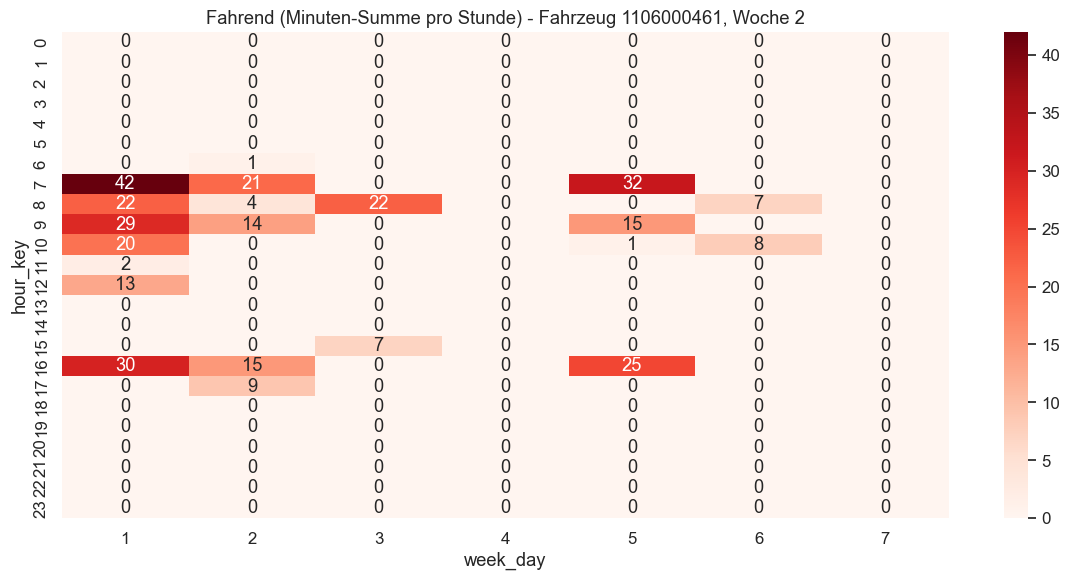

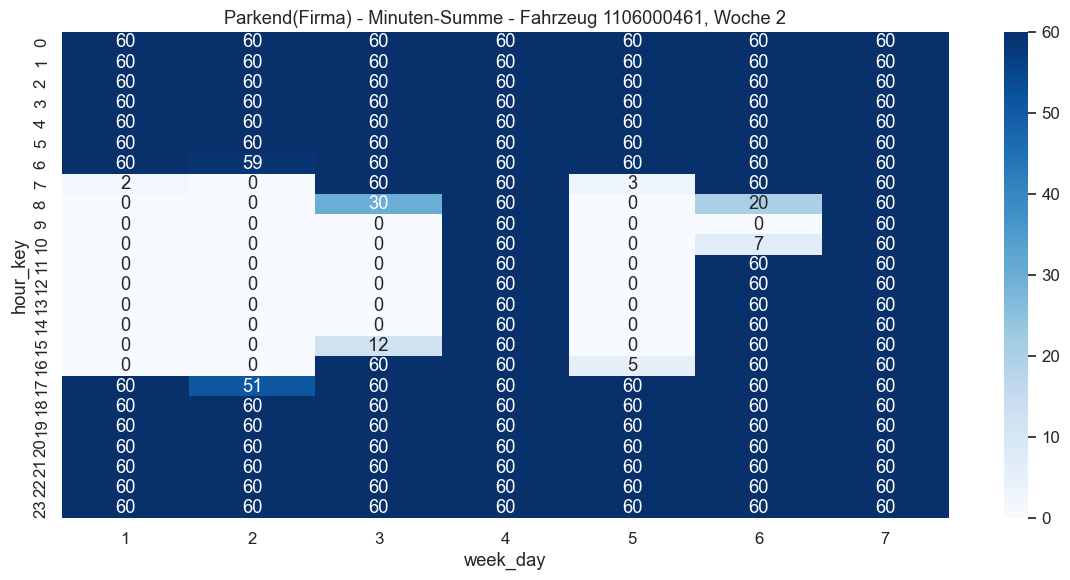

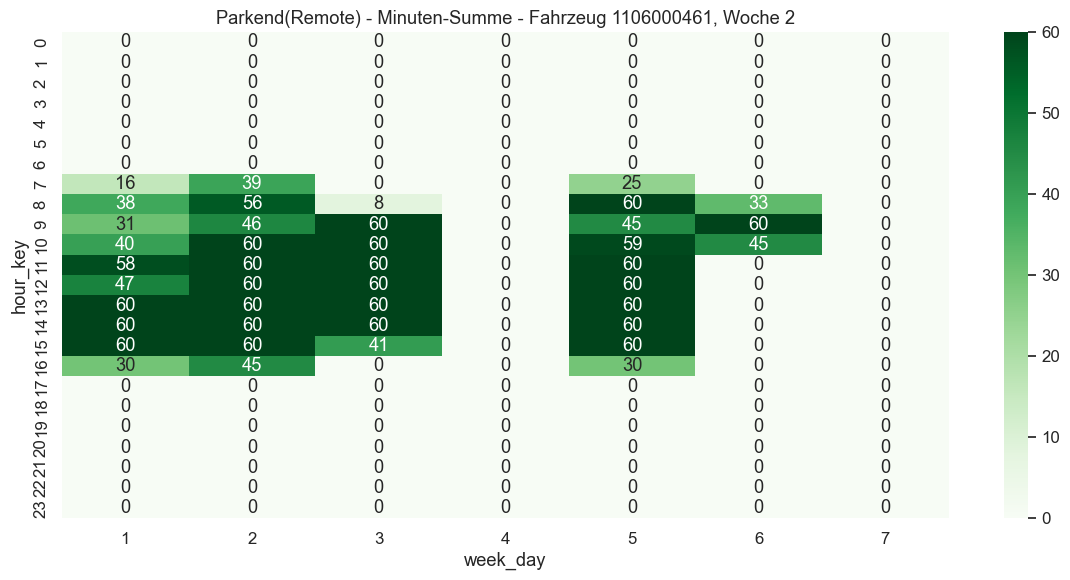

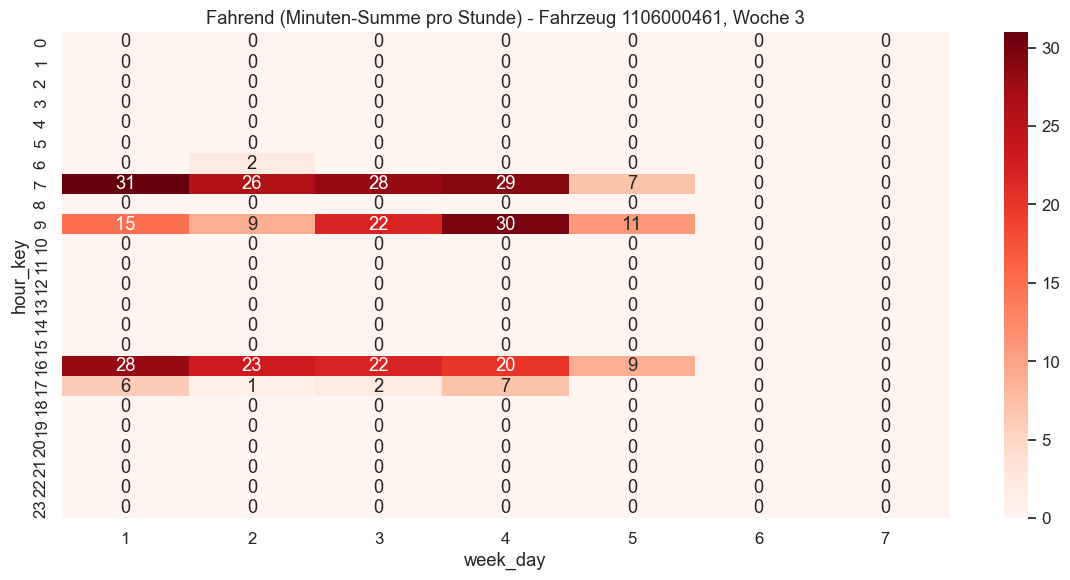

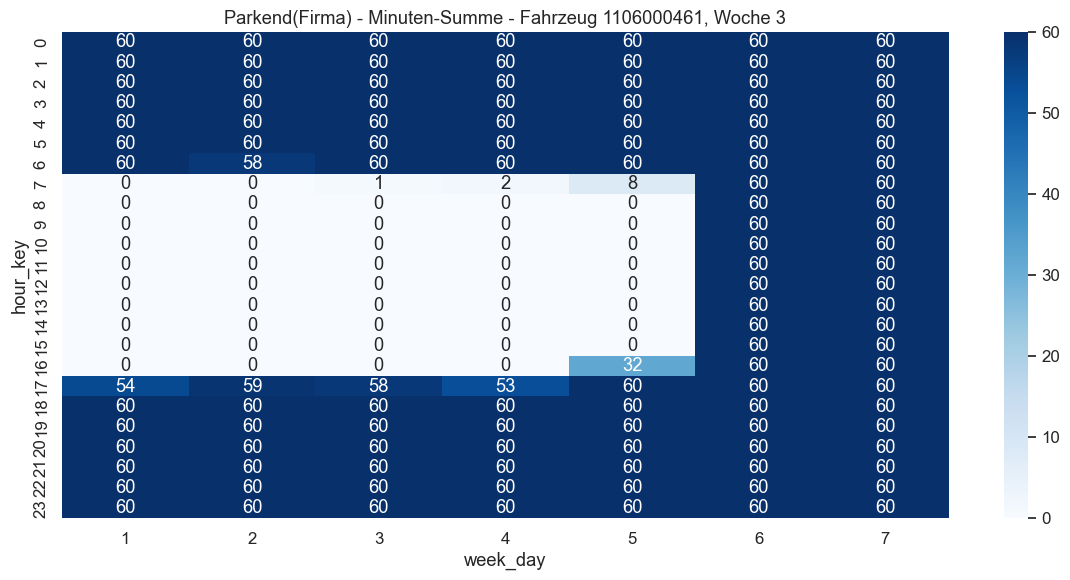

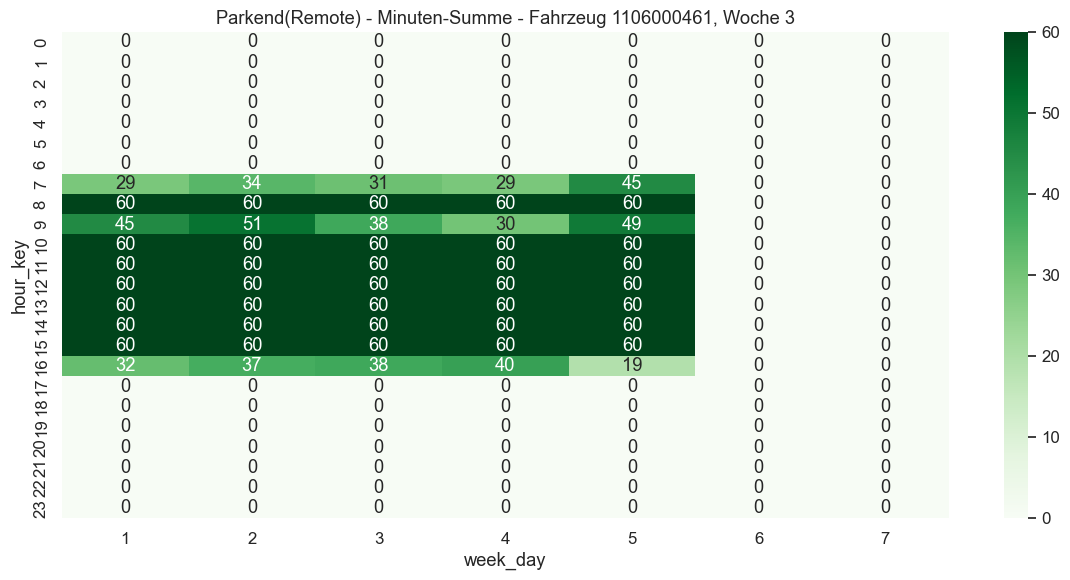

In [13]:
# [8] Beispiel-Heatmaps zur Kontrolle (nur für das konfigurierte Fahrzeug)
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

vid = HEATMAP_VEHICLE_ID
if vid not in summary['id'].unique():
    print(f"Fahrzeug-ID {vid} nicht im Datensatz gefunden.")
else:
    df_v = summary[summary['id'] == vid].copy()
    df_v['hour_key'] = df_v['day_hour']
    
    df_hourly = (
        df_v
        .groupby(['num_week','week_day','hour_key'], as_index=False)[['Fahrend','ParkendFirma','ParkendRemote']]
        .sum()
    )
    
    for w in sorted(df_hourly['num_week'].unique()):
        df_w = df_hourly[df_hourly['num_week'] == w]

        # 1) Fahrend
        pivot_fahrend = df_w.pivot_table(
            index='hour_key',
            columns='week_day',
            values='Fahrend',
            aggfunc='sum'
        )
        plt.figure()
        sns.heatmap(pivot_fahrend, cmap='Reds', annot=True, fmt='.0f')
        plt.title(f"Fahrend (Minuten-Summe pro Stunde) - Fahrzeug {vid}, Woche {w}")
        plt.tight_layout()
        plt.show()

        # 2) Parkend(Firma)
        pivot_pf = df_w.pivot_table(
            index='hour_key',
            columns='week_day',
            values='ParkendFirma',
            aggfunc='sum'
        )
        plt.figure()
        sns.heatmap(pivot_pf, cmap='Blues', annot=True, fmt='.0f')
        plt.title(f"Parkend(Firma) - Minuten-Summe - Fahrzeug {vid}, Woche {w}")
        plt.tight_layout()
        plt.show()

        # 3) Parkend(Remote)
        pivot_pr = df_w.pivot_table(
            index='hour_key',
            columns='week_day',
            values='ParkendRemote',
            aggfunc='sum'
        )
        plt.figure()
        sns.heatmap(pivot_pr, cmap='Greens', annot=True, fmt='.0f')
        plt.title(f"Parkend(Remote) - Minuten-Summe - Fahrzeug {vid}, Woche {w}")
        plt.tight_layout()
        plt.show()